# Step 1: Connect to Google Drive

#2358863_SwarupDevkota

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 2: Import Necessary Libraries

In [ ]:
!gdown 1JMLy-m8guLOiaYJhJTyaoLFd8d61jW8g

Downloading...
From (original): https://drive.google.com/uc?id=1JMLy-m8guLOiaYJhJTyaoLFd8d61jW8g
From (redirected): https://drive.google.com/uc?id=1JMLy-m8guLOiaYJhJTyaoLFd8d61jW8g&confirm=t&uuid=b78d2670-0858-4e78-9c68-7aa7ab4de4aa
To: /content/Scene Classification-20250507T112522Z-1-001.zip
100% 264M/264M [00:03<00:00, 76.3MB/s]


In [ ]:
!unzip "/content/Scene Classification-20250507T112522Z-1-001.zip" -d/content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Scene Classification/train/street/12323.jpg  
  inflating: /content/dataset/Scene Classification/train/street/12203.jpg  
  inflating: /content/dataset/Scene Classification/train/street/12327.jpg  
  inflating: /content/dataset/Scene Classification/train/street/12375.jpg  
  inflating: /content/dataset/Scene Classification/train/street/12392.jpg  
  inflating: /content/dataset/Scene Classification/train/street/1230.jpg  
  inflating: /content/dataset/Scene Classification/train/street/1213.jpg  
  inflating: /content/dataset/Scene Classification/train/street/12415.jpg  
  inflating: /content/dataset/Scene Classification/train/street/12360.jpg  
  inflating: /content/dataset/Scene Classification/train/street/12441.jpg  
  inflating: /content/dataset/Scene Classification/train/street/12162.jpg  
  inflating: /content/dataset/Scene Classification/train/street/12713.jpg  
  inflating: /content/dataset/Scene Cla

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report

# Step 3: Define Paths and Parameters

In [ ]:
# Define paths
train_path = '/content/dataset/Scene Classification/train'  # Update with your path
test_path = '/content/dataset/Scene Classification/test'    # Update with your path

# Parameters
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 6

# Step 4: Data Preparation and Augmentation

In [ ]:
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Function to clean corrupted files
def clean_corrupted_files(directory):
    corrupted = 0
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify that it is an image
            except Exception:
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)
                corrupted += 1
    print(f"✅ Done. Removed {corrupted} corrupted files.")

# Clean corrupted files in the train and test directories
clean_corrupted_files(train_path)
clean_corrupted_files(test_path)

# Data augmentation for training + validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


✅ Done. Removed 0 corrupted files.
✅ Done. Removed 0 corrupted files.
Found 11196 images belonging to 6 classes.
Found 2796 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Step 5: Build CNN Model


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam



def create_baseline_model():
    model = Sequential([
        # Conv Layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),

        # Conv Layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Conv Layer 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Fully Connected Layers
        Dense(256, activation='relu'),
        Dropout(0.5),  # Added to reduce overfitting
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),

        # Output Layer
        Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model

# Create the model
baseline_model = create_baseline_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,604,998 (36.64 MB)

 Trainable params: 9,604,998 (36.64 MB)

 Non-trainable params: 0 (0.00 B)

# Step 6: Define Callbacks

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Step 7: Train the Model

In [ ]:
# Train the model
history = baseline_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 98s 260ms/step - accuracy: 0.2676 - loss: 1.6652 - val_accuracy: 0.5187 - val_loss: 1.2067 - learning_rate: 1.0000e-04
Epoch 2/20
  1/349 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.6562 - loss: 1.0819

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


349/349 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.6562 - loss: 1.0819 - val_accuracy: 0.5244 - val_loss: 1.2103 - learning_rate: 1.0000e-04
Epoch 3/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 113s 244ms/step - accuracy: 0.4922 - loss: 1.2744 - val_accuracy: 0.6121 - val_loss: 1.0506 - learning_rate: 1.0000e-04
Epoch 4/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.6250 - loss: 1.0460 - val_accuracy: 0.6117 - val_loss: 1.0539 - learning_rate: 1.0000e-04
Epoch 5/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 84s 241ms/step - accuracy: 0.5350 - loss: 1.1625 - val_accuracy: 0.6085 - val_loss: 1.0347 - learning_rate: 1.0000e-04
Epoch 6/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.4688 - loss: 1.2026 - val_accuracy: 0.6020 - val_loss: 1.0409 - learning_rate: 1.0000e-04
Epoch 7/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 85s 244ms/step - accuracy: 0.5655 - loss: 1.1026 - val_accuracy: 0.6483 - val_loss: 0.9540 - learning_rate: 1.0000e-04
Epoch 8/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - acc

# Step 8: Evaluate the Model


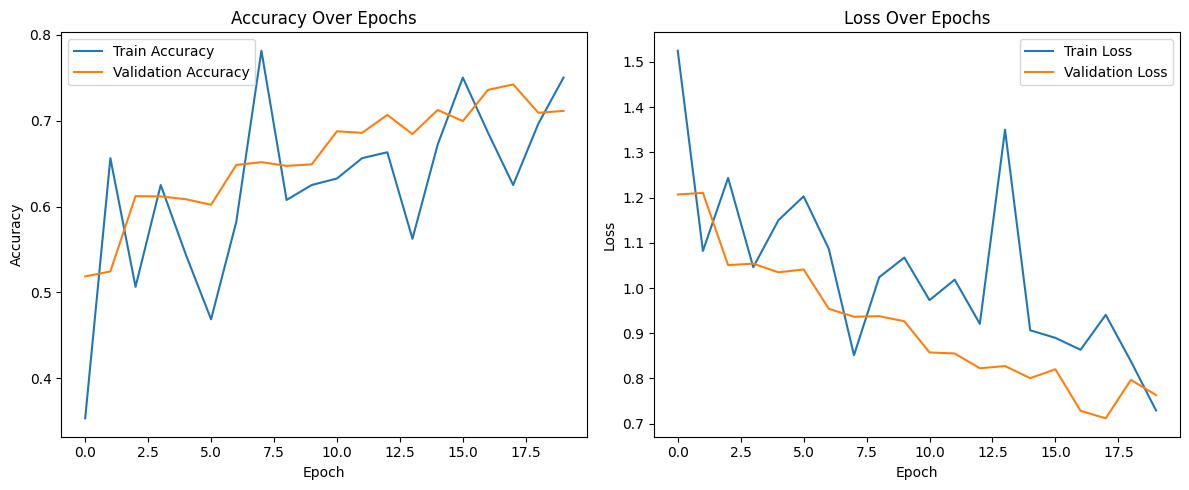

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Step 9: Generate Confusion Matrix


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


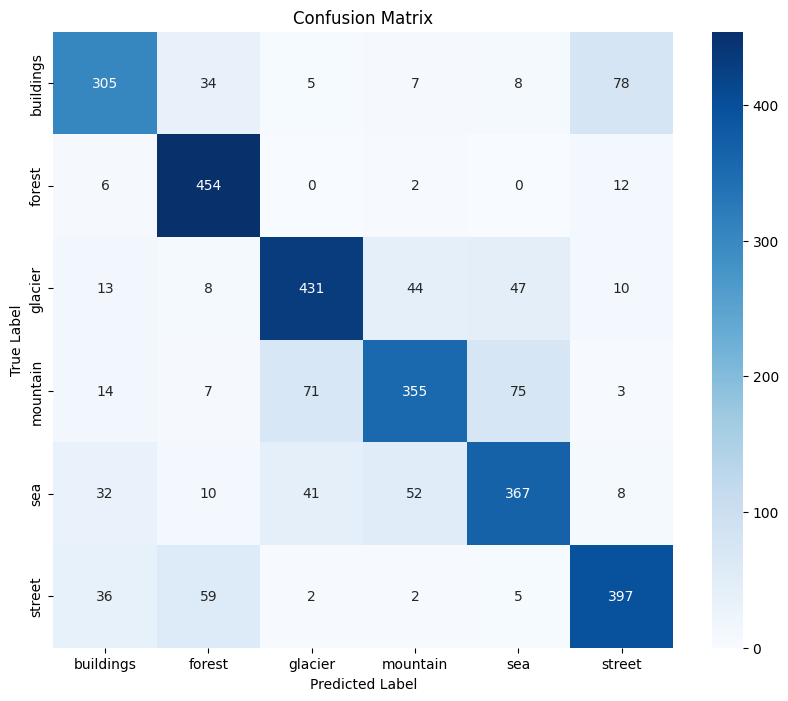

              precision    recall  f1-score   support

   buildings       0.75      0.70      0.72       437
      forest       0.79      0.96      0.87       474
     glacier       0.78      0.78      0.78       553
    mountain       0.77      0.68      0.72       525
         sea       0.73      0.72      0.73       510
      street       0.78      0.79      0.79       501

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000



In [ ]:
# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Step 10: Save the Model

In [ ]:
model.save('scene_classifier.h5')